#  Anomaly - Anomaly Detection & Results Analysis

This notebook focuses on anomaly detection in downtime data and provides a complete summary of pipeline results.

##  Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.getcwd()
if os.path.basename(project_root) in ['pipeline_walkthrough', 'notebooks']:
    project_root = os.path.dirname(project_root)
sys.path.append(project_root)

# Import our pipeline modules
from src.loader import load_operations_data, load_site_meta, merge_data
from src.features import clean_data, engineer_features
from src.anomaly import detect_anomalies_zscore, generate_alerts

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print(" All imports successful!")

 All imports successful!


##  Load & Prepare Data (from previous notebooks)

In [2]:
# Load and prepare data
print(" Loading and preparing data...")
ops_df = load_operations_data()
meta_df = load_site_meta()
df = merge_data(ops_df, meta_df)
df_clean = clean_data(df)
df_features = engineer_features(df_clean)

print(f" Data prepared: {df_features.shape[0]} rows, {df_features.shape[1]} columns")
df_features.head()

 Loading and preparing data...
Looking for file at: c:\Users\hardi\OneDrive\Desktop\task\logic_leap_horizon_datasets\operations_daily_365d.csv
File exists: True
Looking for file at: c:\Users\hardi\OneDrive\Desktop\task\logic_leap_horizon_datasets\site_meta.csv
File exists: True
 Data prepared: 1460 rows, 38 columns


,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,...,units_produced_lag_30,power_kwh_lag_30,units_produced_roll_mean_7,power_kwh_roll_mean_7,units_produced_roll_mean_14,power_kwh_roll_mean_14,units_produced_roll_mean_30,power_kwh_roll_mean_30,efficiency,downtime_ratio
0,2025-01-01,S1,1280,34,4211,27,453,56,71.94,96.04,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.303966,0.028333
1,2025-01-02,S1,1249,193,5471,40,480,55,71.87,95.90,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.228295,0.160833
2,2025-01-03,S1,1163,43,4178,33,454,53,72.04,96.11,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.278363,0.035833
3,2025-01-04,S1,1348,32,4554,35,387,54,72.26,95.99,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.296004,0.026667
4,2025-01-05,S1,0,0,0,0,0,0,0.00,0.00,...,1280.0,4211.0,1101.714286,3884.571429,1169.428571,4146.357143,1121.7,3878.966667,0.000000,0.000000


##  Phase 5: Anomaly Detection

Now let's detect anomalies in the downtime data.

In [3]:
# Detect anomalies
print(" Detecting anomalies in downtime data...")
df_anomalies = detect_anomalies_zscore(df_features, 'downtime_minutes', 3.0)


# Generate alerts
alerts_df = generate_alerts(df_anomalies)


print(" Anomaly detection complete!")
print(f" Total anomalies detected: {len(alerts_df)}")
print(f" Anomalies by site: {alerts_df['site_id'].value_counts().to_dict()}")
print(f" Detection method: Z-score (threshold = 3.0sigma)")

 Detecting anomalies in downtime data...
 Anomaly detection complete!
 Total anomalies detected: 61
 Anomalies by site: {'S1': 17, 'S4': 16, 'S2': 15, 'S3': 13}
 Detection method: Z-score (threshold = 3.0sigma)


In [4]:
# Show sample alerts
print("\n SAMPLE ANOMALY ALERTS")
print("=" * 60)

for i, (_, alert) in enumerate(alerts_df.head(5).iterrows()):
    print(f"\n{i+1}. {alert['description']}")
    print(f"   Site: {alert['site_id']} | Date: {alert['date']} | Z-score: {alert['zscore']:.1f}")

if len(alerts_df) > 5:
    print(f"\n... and {len(alerts_df) - 5} more alerts")

alerts_df.head()


 SAMPLE ANOMALY ALERTS

1. Downtime 293min exceeds normal by 4.7sigma
   Site: S1 | Date: 2025-01-12 00:00:00 | Z-score: 4.7

2. Downtime 222min exceeds normal by 3.3sigma
   Site: S1 | Date: 2025-03-13 00:00:00 | Z-score: 3.3

3. Downtime 211min exceeds normal by 3.1sigma
   Site: S1 | Date: 2025-03-24 00:00:00 | Z-score: 3.1

4. Downtime 215min exceeds normal by 3.1sigma
   Site: S1 | Date: 2025-04-19 00:00:00 | Z-score: 3.1

5. Downtime 236min exceeds normal by 3.6sigma
   Site: S1 | Date: 2025-04-26 00:00:00 | Z-score: 3.6

... and 56 more alerts


,date,site_id,downtime_minutes,zscore,alert_type,description
11,2025-01-12,S1,293,4.733106,High Downtime,Downtime 293min exceeds normal by 4.7sigma
71,2025-03-13,S1,222,3.275870,High Downtime,Downtime 222min exceeds normal by 3.3sigma
82,2025-03-24,S1,211,3.050101,High Downtime,Downtime 211min exceeds normal by 3.1sigma
108,2025-04-19,S1,215,3.132199,High Downtime,Downtime 215min exceeds normal by 3.1sigma
115,2025-04-26,S1,236,3.563212,High Downtime,Downtime 236min exceeds normal by 3.6sigma


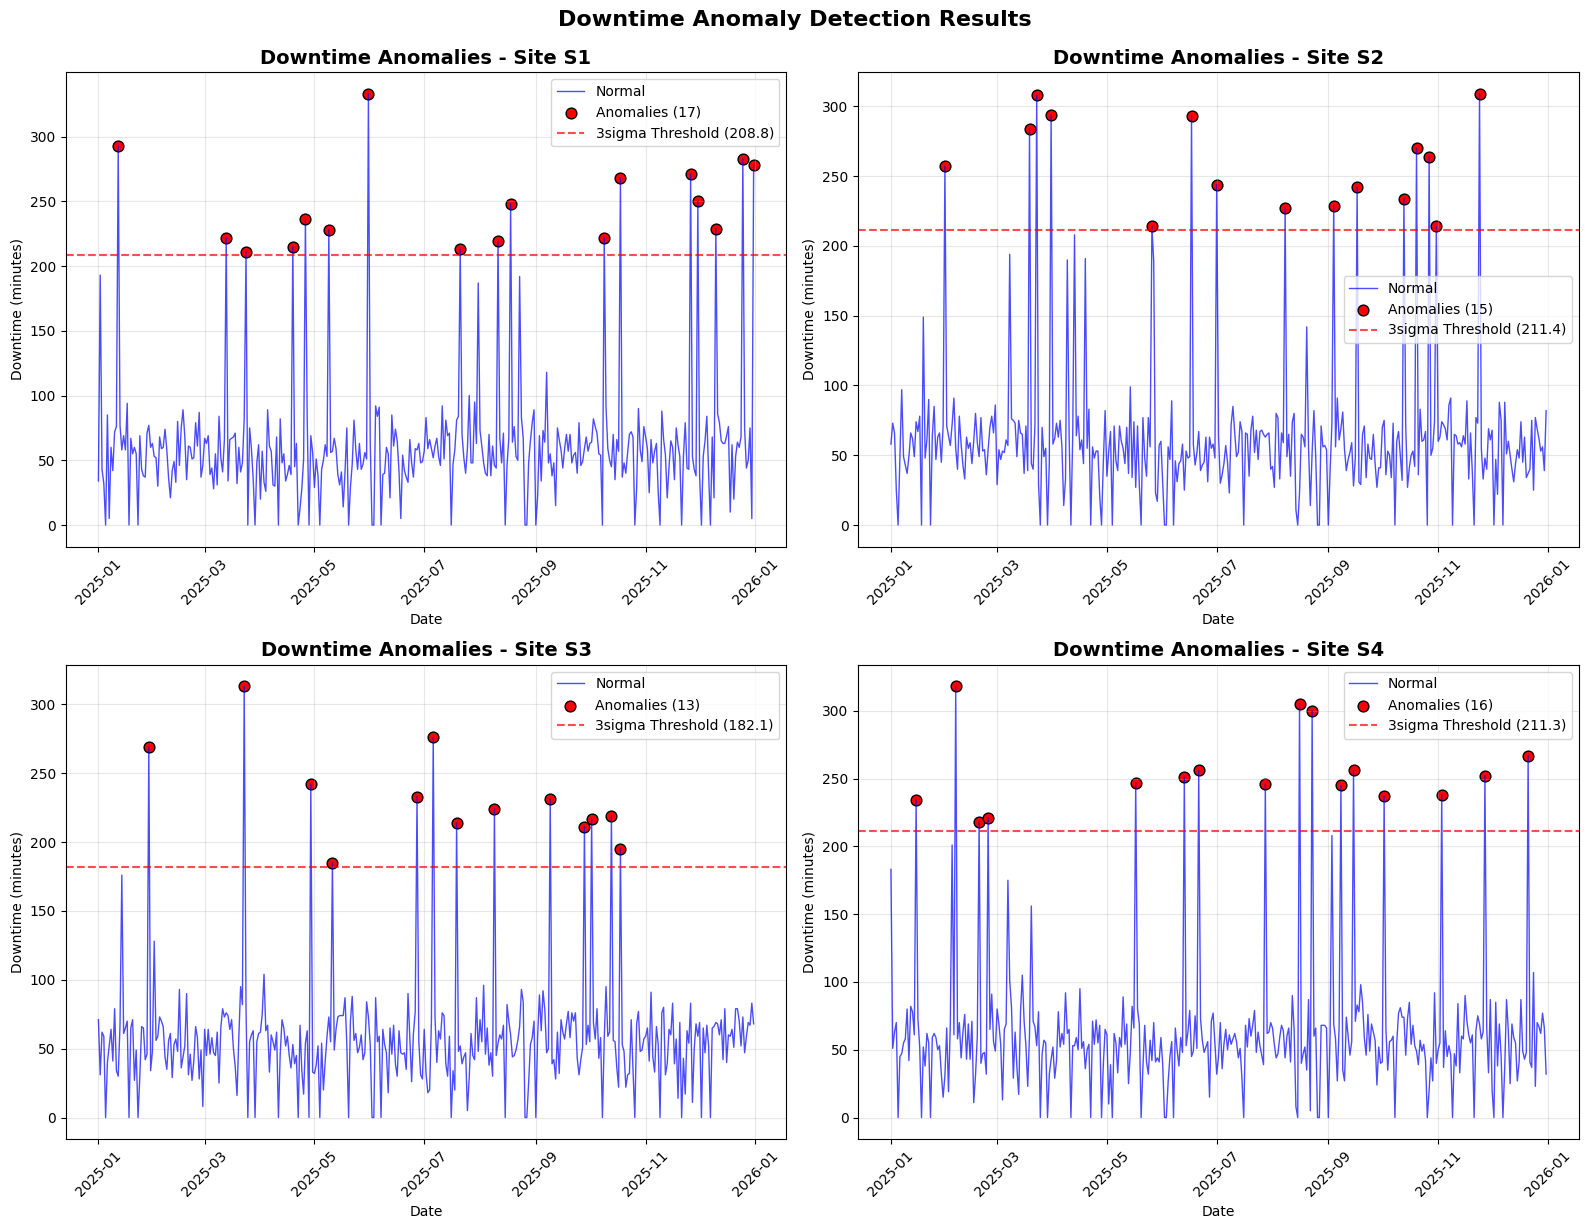


 Anomaly Detection Insights:
 Red dots indicate detected anomalies
 Horizontal red line shows 3sigma threshold
 Anomalies represent statistically significant downtime events
 Different sites have different baseline downtime patterns


In [5]:
# Visualize anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, site in enumerate(sorted(df_anomalies['site_id'].unique())):
    site_data = df_anomalies[df_anomalies['site_id'] == site]
    anomalies = site_data[site_data['anomaly'] == True]
    
    # Plot downtime over time
    axes[i].plot(site_data['date'], site_data['downtime_minutes'], 'b-', alpha=0.7, linewidth=1, label='Normal')
    
    # Highlight anomalies
    if len(anomalies) > 0:
        axes[i].scatter(anomalies['date'], anomalies['downtime_minutes'], 
                       color='red', s=60, edgecolor='black', linewidth=1, 
                       label=f'Anomalies ({len(anomalies)})') 
    
    # Add threshold line (3sigma)
    mean_downtime = site_data['downtime_minutes'].mean()
    std_downtime = site_data['downtime_minutes'].std()
    threshold = mean_downtime + 3 * std_downtime
    axes[i].axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
                   label=f'3sigma Threshold ({threshold:.1f})')
    
    axes[i].set_title(f'Downtime Anomalies - Site {site}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Downtime (minutes)')
    axes[i].legend()
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.suptitle('Downtime Anomaly Detection Results', fontsize=16, fontweight='bold', y=1.02)
plt.show()


print("\n Anomaly Detection Insights:")
print(" Red dots indicate detected anomalies")
print(" Horizontal red line shows 3sigma threshold")
print(" Anomalies represent statistically significant downtime events")
print(" Different sites have different baseline downtime patterns")

##  Phase 6: Results Analysis & Summary

Let's analyze the complete results and create summary outputs.

In [ ]:
# Create outputs directory
os.makedirs('outputs', exist_ok=True)

# Save results to CSV files
print(" Saving results to CSV files...")

# Alerts
alerts_df.to_csv('outputs/alerts.csv', index=False)
print(" Saved alerts.csv")

print("\n All output files saved to outputs/ directory")

print(" PIPELINE EXECUTION SUMMARY")
print("=" * 60)
print(f" Input Data: {len(df)} records across {len(df['site_id'].unique())} sites")
print(f" Features Engineered: {len(df_features.columns) - len(df.columns)} new features")
print(f" Anomalies Detected: {len(alerts_df)} alerts")
print(f" Output Files: alerts.csv saved")

print("\n PERFORMANCE HIGHLIGHTS:")
print(f" Anomaly Detection: {len(alerts_df)} significant downtime events identified")
print(" Detection Method: Z-score analysis (3.0sigma threshold)")
print(" Alert Generation: Automated descriptions and severity levels")

print("\n PIPELINE STATUS: COMPLETE")
print(" All anomaly detection deliverables generated successfully!")

 Saving results to CSV files...
 Saved alerts.csv

 All output files saved to outputs/ directory
 PIPELINE EXECUTION SUMMARY
 Input Data: 1460 records across 4 sites
 Features Engineered: 22 new features
 Anomalies Detected: 61 alerts
 Output Files: alerts.csv saved

 PERFORMANCE HIGHLIGHTS:
 Anomaly Detection: 61 significant downtime events identified
 Detection Method: Z-score analysis (3.0sigma threshold)
 Alert Generation: Automated descriptions and severity levels

 PIPELINE STATUS: COMPLETE
 All anomaly detection deliverables generated successfully!


: 